In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

## User settings

In [2]:
N = 200 # number of nodes
L = 1 # domain length
dt = 0.001 # time step
t0 = 0 # initial time instant

U = 1 # convection velocity

theta = .5 # value of theta specifying method in time

refresh_time = 1 # basically the inverse of the framerate, in MILLISECONDS

## Actual code

Mesh and stability check:

In [3]:
x = np.linspace(0, L, num=N)
dx = L/(N-1) # grid resolution
print() # new line
print('CFL number: ', dt*U/dx) # CFL umber (stab. of convection in time)
print() # new line


CFL number:  0.199



Calculation of matrix B for centered in space scheme:

In [4]:
# calcolate coefficients for centered
BEC =   -  U / (2*dx)
BWC =      U / (2*dx)
BPC =          0     

# calculate matrix B for centered
BC = BWC*np.diag(np.ones(N-1),-1) + BEC*np.diag(np.ones(N-1),1) + BPC*np.diag(np.ones(N))

# make B periodic: last row takes info from first point
BC[-1, 1] = BC[-2,-1]

Calculation of matrix B for upwind scheme:

In [5]:
# calculate coefficients for upwind
BEU = - min(U,0) / dx
BWU = max(U,0) / dx
BPU = -(BEU+BWU)

# calculate matrix B for upwind
BU = BWU*np.diag(np.ones(N-1),-1) + BEU*np.diag(np.ones(N-1),1) + BPU*np.diag(np.ones(N))

# make B periodic: last row takes info from second point
BU[-1, 1] = BU[-2,-1]

Function to apply boundary conditions:

In [6]:
def apply_bc(M,v):
    # this takes a matrix and a vector and modifies first and last row
    # in order to account for boundary conditions

    # delete first row
    M[0,:] = 0

    # first row becomes:
    # first point = last point; Neumann like
    M[0,0] = 1
    M[0,-1] = -1
    v[0] = 0

    return M,v

Function that returns exact solution at given time:

In [7]:
def get_exact():
    a = (x-U*t0)%L
    return 16*((a**2)*(L-a)**2)/(L**4)

Initial condition:

<IPython.core.display.Javascript object>


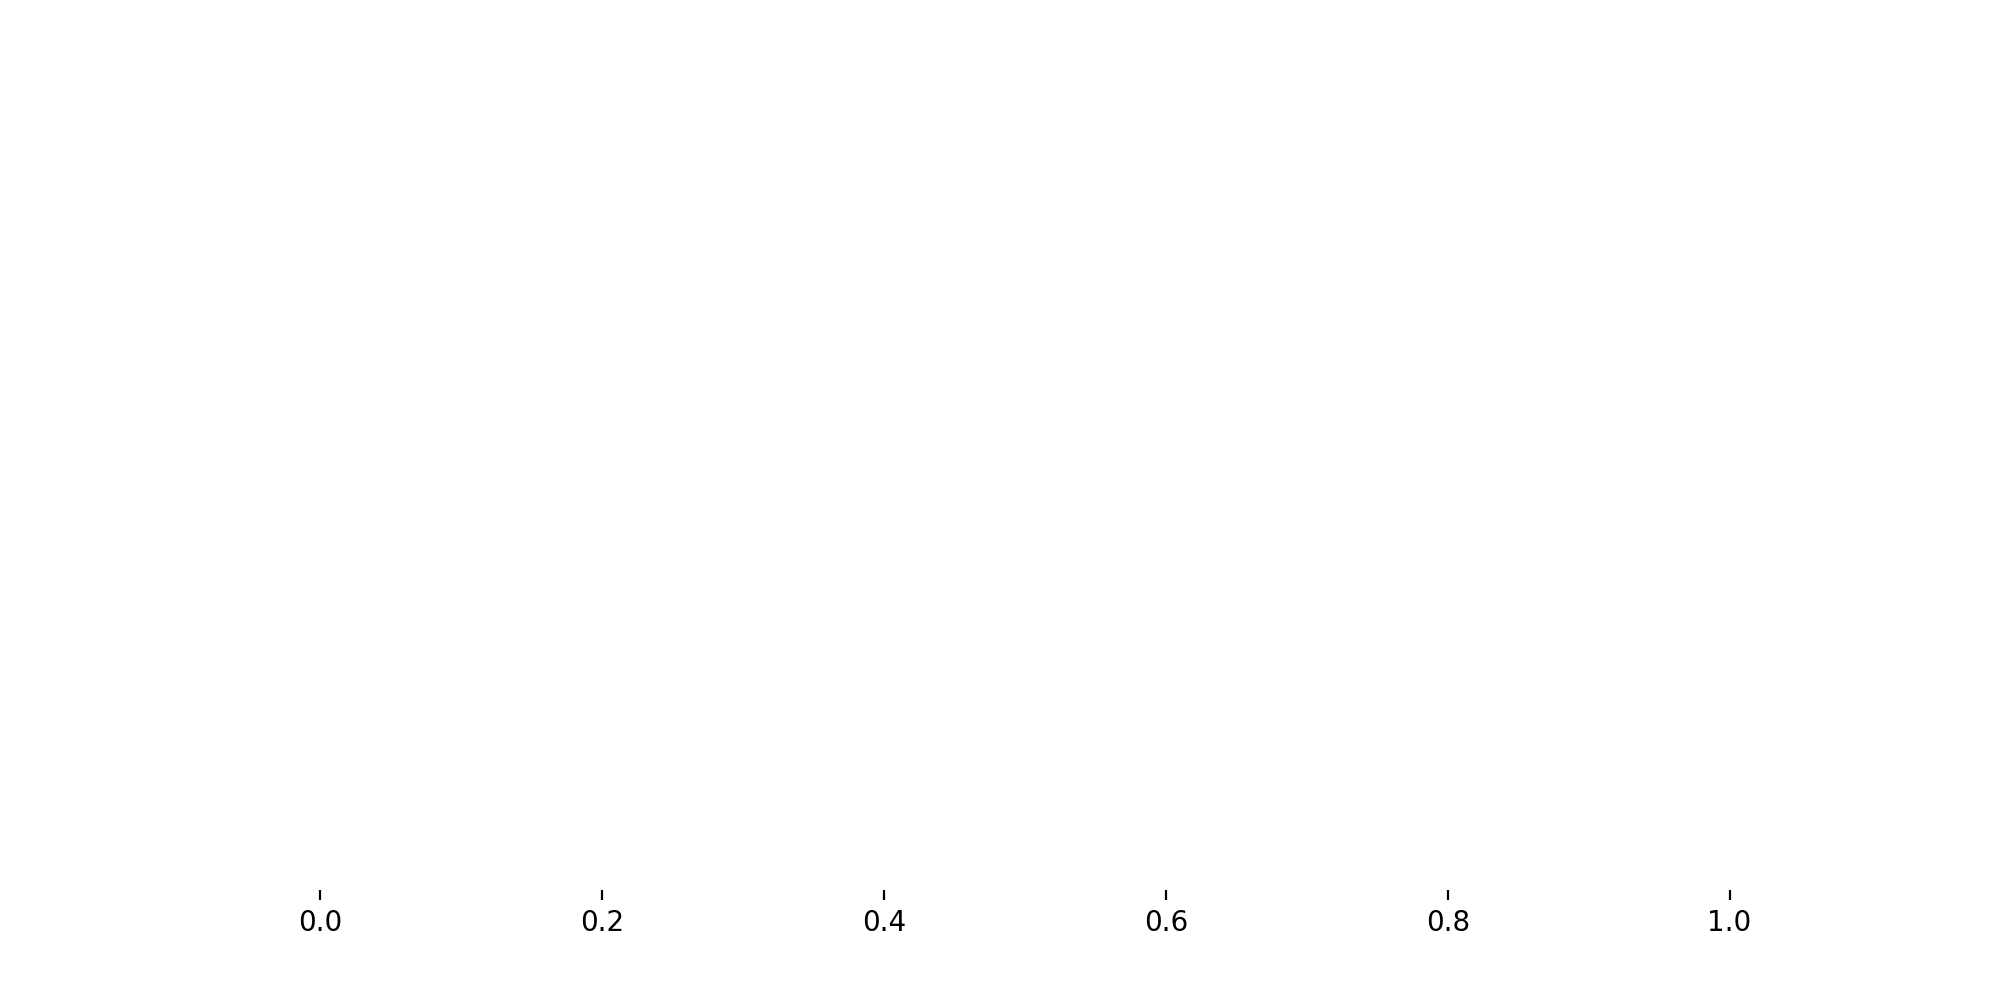

In [8]:
# initialise exact solution
exact_sol = get_exact()

# centered
c_curr = get_exact() # initial condition
c_new = np.zeros_like(x) # temperature at next time step
b_c = np.zeros_like(x) # right hand side vector

# upwind
u_curr = get_exact() # initial condition
u_new = np.zeros_like(x) # temperature at next time step
b_u = np.zeros_like(x) # right hand side vector

# plot it
fig, ax = plt.subplots(figsize=(10,5))
c_plot = ax.plot(x, c_curr) # update me!
u_plot = ax.plot(x, u_curr) # update me!
exact_plot = ax.plot(x, exact_sol) # update me!
ax.set_title('t = '+str(round(t0, 3))) # update me!
ax.legend(['centered', 'upwind', 'exact'])

Matrices for time step:

In [9]:
# Matrix of coefficients (multiplies T_{n+1})
AC = np.identity(N) - dt * theta * BC
AU = np.identity(N) - dt * theta * BU


# Matrix that returns know term
EC = np.identity(N) + dt * (1-theta) * BC
EU = np.identity(N) + dt * (1-theta) * BU

# A * t_new = E * t_curr

Time step function:

In [10]:
def time_step(ii):

    global c_curr, c_new, u_curr, u_new, b_c, b_u, AC, AU, EC, EU, t0, exact_sol

    # get known term and apply bc
    b_c[:] = EC.dot(c_curr)
    b_u[:] = EU.dot(u_curr)
    AC,b_c = apply_bc(AC,b_c)
    AU,b_u = apply_bc(AU,b_u)

    # solve system
    c_new[:] = np.linalg.solve(AC,b_c)
    u_new[:] = np.linalg.solve(AU,b_u)

    # update
    t0 += dt
    buffer_pointer = c_curr
    c_curr = c_new
    c_new = buffer_pointer
    buffer_pointer = u_curr
    u_curr = u_new
    u_new = buffer_pointer
    exact_sol[:] = get_exact()

    # plot
    c_plot[0].set_ydata(c_curr)
    u_plot[0].set_ydata(u_curr)
    exact_plot[0].set_ydata(exact_sol)
    ax.set_title('t = '+str(round(t0, 3)))

    return c_plot, u_plot, exact_plot

Animation:

In [11]:
animation = FuncAnimation(fig, func=time_step, interval=refresh_time)
plt.show()